# Information Retrieval project 2023  
### INVESTIGATING OR ANALYSING MATERIALS BY DETERMINING THEIR CHEMICAL OR PHYSICAL PROPERTIES

## 🧑‍🎓 Names of the team members
+ Efoe Etienne Blavo
+ Tonga Junior Cedric

# ✅import libraries

In [2]:
import json
import numpy as np
import re
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import spacy
from spacy.matcher import PhraseMatcher, Matcher
from spacy.util import filter_spans
from spacy import displacy
from spacy.tokens import DocBin
from spacy.tokens import Span
import networkx as nx
import matplotlib.pyplot as plt
from psutil import process_iter
from signal import SIGTERM 
import os
import textacy
tqdm.pandas()

spacy.__version__


'3.3.2'

## ✅Overall abstract of the project :
In this project, it was a question of designing a model capable of recognizing terms related to our field which is: `INVESTIGATING OR ANALYSING MATERIALS BY DETERMINING THEIR CHEMICAL OR PHYSICAL PROPERTIES`. 
We built our gold set according to the steps you will see below, then we trained the spacy model on our patent to see how it recognizes terms. The model we got recognized some irrelevant and out of context terms, so we used prodigy to correct these errors. Then we re-trained and re-evaluated on the test set. However, we also tried to fine tune Bert's variants, more precisely roberta and distillbert, but we couldn't get to the end due to lack of computing power. The idea was to also make the transformers and compare them to the basic models of spacy.

The second part of the project deals with the extraction of relationships between entities. We considered an entity as a verb or a verb phrase that links two entities in the style subject verb object. We used the noun chunks approach but it turns out that the relations found do not always make sense, this is surely because the noun chunks are not all related to our domain. That's why we used our model to extract the entities linked to our domain. And then extract the verb phrases that link the entities according to the rule defined above.


## 1 -Term extraction


✔️Goal of this part: extract terms from the corpus

Our first goal here is to create a model capable of recognizing the term in our patents. For that, we will be using a Named Entity Recognition model given by `spacy`.

✔️ What's a Term? 

A clear and specific word related to our domain

### ➡️ Download and Load base spacy models 

In [ ]:
#uncomment if you want to use transformer model
#!python -m spacy download en_core_web_trf 
!python -m spacy download en_core_web_lg

In [3]:
nlp = spacy.load("en_core_web_lg") # load spacy model see https://spacy.io/models/en#en_core_web_lg
#nlp=spacy.load('en_core_web_trf') uncomment if you want to use transformer spacy model see https://spacy.io/models/en#en_core_web_trf

check the availability of GPU in case we want to train transformer model

In [3]:
spacy.require_gpu() 

True

 ## ✅ Read the data

In [4]:
patent_data = open('G01N.txt').read().strip()

# split into patents texts | 1 entry = 1 patent
patent_texts = patent_data.split('\n\n')

# split each patent into lines
patent_lines = patent_data.split('\n')

print(len(patent_lines))
print(len(patent_texts))

330594
2139


### ➡️Read manyterms file

In [4]:
# here are the potential terms
mwes = open('manyterms.lower.txt').read().lower().strip().split('\n')
print(mwes[1:10])
print(len(mwes), 'mwes')


['0 0254 metres', '0 1 integer program', '0 17 fireball', '0 17 remington', '0 17 remington fireball', '0 2 tactical', '0 20 tactical', '0 22 accelerator', '0 22 br remington']
743274 mwes


In [5]:
def get_feature_names(vectorizer):
    if hasattr(vectorizer, 'get_feature_names'):
        return vectorizer.get_feature_names()
    else:
        return vectorizer.get_feature_names_out()

### ➡️Extracting terms from our patents using manyterms

In [33]:
cvectorizer = CountVectorizer(ngram_range=(
    1, 4), stop_words="english", vocabulary=mwes, lowercase=True)
X = cvectorizer.fit_transform(patent_texts)

# Show top-10 most frequent terms
termdf_cv = pd.DataFrame(np.sum(X, axis=0), columns=get_feature_names(cvectorizer)).T.sort_values(by=0, ascending=False)
termdf_cv.head(5)

c:\Users\junio\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1380: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


,0
amino acid,24339
nucleic acid,13185
amino acid sequence,11407
light source,6943
amino acids,6170


### ➡️Filter out terms that occur less than 2 times and  save terms to file

In [36]:
termdf_cv = termdf_cv[termdf_cv[0] >= 1] 
termdf_cv.to_csv('terms_v3.tsv', sep='\t') 

### ➡️useful functions

In [6]:
# Function from TP5 that we reused here
def combineFreqDics(freq_dic):
    """
    function that combines entries of the freq_dic if they only differ in case into the most frequent case version
    """
    combined_dict = {}

    for key, value in freq_dic.items():
        normalized_key = key.lower()
        if normalized_key not in combined_dict:
            combined_dict[normalized_key] = (key, value)
        else:
            orig_key, orig_value = combined_dict[normalized_key]
            combined_dict[normalized_key] = (
                key if value > orig_value else orig_key, orig_value + value)

    return {key: value for key, value in combined_dict.values()}


def is_plural(singular, plural):
    return singular + 's' == plural or singular == plural + 's'


def rawExtractRefs(text, allnums=True, multipleResults=True):
    """
    text: the text potentially containing reference numerals
    NO: termjson: json as send back to the frontend
    allnums: if true also terms without parentheses
    """
    if allnums:
        renum = re.compile(r'[ (]\d+[) .,]')
    else:
        renum = re.compile(r'\(\d+\)')
    num2term = {}
    # print(111,'a\ba',222,r'\b|\b'.join('the a an to for under behind above least on which and or Figure \W*\d+\W*'.split()),333,'\b'+'\b|\b'.join('the a an to for under behind above least on which and or Figure \W*\d+\W*'.split())+r'\b')
    excluders = '''the a an 
    to for of under behind above least on which and or more all 
    Claim Claims Figure Figures Fig Figs'''
    noterms = re.compile(r'\b'+r'\b|\b'.join((excluders +
                         ' \W*\d+\W* \W*[,."()]+\W*').split())+r'\b'+r'|\W*[:;,?*%$=+()]+\W*', re.I)
    for m in renum.finditer(text):  # all number mathes
        i = int(m.group(0)[1:-1])

        potwords = text[0:m.start(0)].split()[-4:]
        # print(222,potwords)
        for j in range(len(potwords)):
            tu = ' '.join(potwords[j:])
            if not noterms.search(tu):
                num2term[i] = num2term.get(i, {})
                num2term[i][tu] = num2term[i].get(tu, 0)+1
        # print(333, [tuple(potwords[j:]) for j in range(len(potwords))], i)
    # print(444, num2term)
    num2termlist = {}
    for num, td in num2term.items():
        ctd = combineFreqDics(td)
        # print("555 ctd:",ctd)
        ma = max(ctd.values())
        mas = [(k, v) for k, v in ctd.items() if v == ma]
        # print('mas',mas)
        filtered_list = []
        for t, j in mas:
            add_to_list = True
            for s, i in mas:
                # is subset the right thing here?
                if t != s and set(t).issubset(set(s)):
                    add_to_list = False
                    break
            if add_to_list:
                filtered_list.append(t)
                # Check for less frequent terms that just differ in number
                for key, value in ctd.items():
                    if is_plural(t, key) and key not in filtered_list:
                        filtered_list.append(key)
                    elif is_plural(key, t) and t not in filtered_list:
                        filtered_list.append(t)

        # print('--->',filtered_list)
        num2termlist[num] = filtered_list
    return num2termlist

def removeNumbers(text, num2termlist):
    terms = [val for sublist in num2termlist.values() for val in sublist]
    numterms = re.compile(r'(\b'+r'\b|\b'.join(terms) +
                          r'\b) *[ (]\d+([) ]|([.,:]*)) *()', re.I)
    clean_text = numterms.sub(r'\1\3 ',text)
    return clean_text

In [7]:
# fucntion from tp5 that we reused here to get noun chunks
def get_noun_chunks(doc):
    noun_chunks = []
    for chunk in doc.noun_chunks:
        # Remove determiners from the noun chunk
        chunk_text = ' '.join([token.text for i, token in enumerate(
            chunk) if not (i == 0 and token.pos_ == 'DET')])

        # Get the start and end character positions of the modified noun chunk
        start_char = doc[chunk.start].idx if doc[chunk.start].pos_ != 'DET' else doc[chunk.start].nbor(
        ).idx
        end_char = start_char + len(chunk_text)

        noun_chunks.append({
            'start': start_char,
            'end': end_char,
            'label': 'NC',
            'text': chunk_text
        })
    return noun_chunks

In [8]:
# function from tp5 that we reused here to get noun chunks and remove some of them which are not useful
def get_noun_chunks(doc, remove_list=[], exclude_list=[]): 
    noun_chunks = []
    for chunk in doc.noun_chunks:
        exclude_list += ['that', 'which']
        if any(token.text in exclude_list for token in chunk):
            continue

        filtered_tokens = [
            token for token in chunk
            if token.dep_ != "relcl" and token.text not in remove_list and token.pos_ != 'DET' and not token.is_punct
        ]

        if not filtered_tokens:
            continue

        chunk_text = ' '.join(token.text for token in filtered_tokens)
        chunk_text = chunk_text.replace('"', '').replace("'", "")

        start_char = filtered_tokens[0].idx
        end_char = start_char + len(chunk_text)

        noun_chunks.append({
            'start': start_char,
            'end': end_char,
            'label': 'NC',
            'text': chunk_text
        })

    return noun_chunks


remove_list = ['said', 'simply']
exclude_list = ['FIG', 'FIGS',"other components","Invention","invention",
"compound","other diseases","plates","what","Examples","inventor","results","case",
"diagram","addition","functions","samples","Preparation","confirmation","plate",
"same meaning","donors","film","layer","object","ratio","carrier","initiator","with"
,"Figures","washing","pattern","some","sera","patients","detection","Detection",
"chip","Figure","more detail","examples","Example","photograph","films","details","fields",
"Summary","content","weight","carrier","initiator","Effects", "that", "which", "who", "whom", 
"whose","claim", "smax", "ref", "sout", "savg", "ref", "smax", "ref", "savg", "claims", "Fig", 
'field',  'result',  'order',  'view',  'aspect',  'reference',  'shape',  'like',  'manner',  
'background art',  'prior art',  'intensive studies',  'same meanings',  'definition',  'one aspect', 
 'person',  'art',  'conflict',  'present description',  'example',  'more detail',  'means',  'completion', 
  'direct use',  'surface',  'condition',  'frequency',  'incubation',  'color development',  'dark',  'result', 
   'location spots',  'blank control',  'visual observation',  'contrast',  'typical case',
  'above results',  'specific embodiments',  'scope',  'way',  
  'present invention', 'That', 'these', 'well', 'item', 'items'] # we added some words to the list to remove

In [40]:
# Here we did some processing to get the noun chunks from 5 patents by removing nouns chunks 
# which nouns chunks that contain numbers or less than 3 words

all_chunk=[]
for patent_text in tqdm(patent_texts[:5]):  # 5 patents, we can take more
    shortText = patent_text
    doc = nlp(shortText)
    num2termlist = rawExtractRefs(shortText)
    cleanNshort = removeNumbers(shortText, num2termlist)
    doc = nlp(cleanNshort)
    get_noun_chunks(doc)
    noun_chunks = get_noun_chunks(doc, remove_list, exclude_list)
    
    
    for ent in noun_chunks:
        if re.search(r'\d+', ent['text']) or len(ent['text']) < 3 : # remove nouns chunks with number and less than 3 words
            continue
        print(ent['text'])
        all_chunk.append(ent['text'])

  0%|          | 0/5 [00:00<?, ?it/s]

SOLID
PHASE CARRIER
IMPROVING DETECTION SENSITIVITY
DETECTION COMPONENT
titanium dioxide particles
Technical Field
functional materials
substrate
Background Art 
 A polydimethylsiloxane
PDMS hereinafter
excellent properties
non
toxicity
transparency
elasticity
chemical inertness
preferred functional material
applications
microfluidic systems
micro electromechanical systems
soft lithography
unconventional nanolithography
PDMS based device
application
PDMS
PDMS
PDMS
Chinese Patent Publication No CN A
polydimethylsiloxane
iPDMS
non specific adsorption
proteins
above mentioned iPDMS material
substrate
above mentioned technical problem
intensive studies
above mentioned technical problem
titanium dioxide particles
iPDMS material
andtitanium dioxide particles
titanium dioxide particles
titanium dioxide particles
average particle size
preferably nm
anda polypeptide
protein
oligomeric ethylene glycol methacrylate
Brief Description
Drawings 
  EPO
polypeptide microarray
serum sample
sample dilut

In [41]:
# Take a set of all the noun chunks in other to remove duplicates
all_chunk = list(set(all_chunk))
all_chunk[:10]

['anti human IgG antibody',
 'band;e',
 'diverging beam',
 'percentage',
 'focal point',
 'relatively low absorption',
 'binary gas mixture',
 'same time',
 'cross machine direction',
 'passage']

In [42]:
# merge manyterms list with all_chunk list

gold = set(all_chunk + termdf_cv.index.tolist())
gold=list(gold)
gold[:10]


['coconut oil',
 'test method',
 'relatively low absorption',
 'cold cathode',
 'crystalline form',
 'conveyor chain',
 'pituitary adenoma',
 'brønsted acid',
 'magnetic noise',
 'snow cover']

In [43]:
#save the gold list in a file and add the tag CH for each term so that it can have the required format for prodigy
gold_df=pd.DataFrame(gold,columns=['term'])
gold_df['ner_tag']=['CH']*len(gold_df)
gold_df.to_csv('gold2.csv',index=False) # save gold standard
gold_df.head()

,term,ner_tag
0,coconut oil,CH
1,test method,CH
2,relatively low absorption,CH
3,cold cathode,CH
4,crystalline form,CH


we used the gold_df to create a pattern file to use it in  prodigy in other to label the data with ner.manual.

so the cell below is to create the pattern file from the gold_df. 

That pattern file is a jsonl file that contains the terms and their labels. And you can use it in prodigy

as patterns to annotate the data with ner.manual recipe. It permits to label the data faster.

In [44]:
gold_df_dic= gold_df.to_dict(orient='records')
gold_df_dic

patterns = []
for record in gold_df_dic:
    pattern = {"label": record["ner_tag"], "pattern": [{"lower": record["term"]}]}
    patterns.append(pattern)

with open('patterns.jsonl', 'w', encoding='utf-8') as f:
    for pattern in patterns:
        f.write(json.dumps(pattern, ensure_ascii=False) + '\n')

### ✅ Let's see how spacy works on our dataset

In [45]:
nlp = spacy.load("en_core_web_lg")
doc = nlp(patent_texts[0][10000:12000])
displacy.render(doc, style="ent", jupyter=True)

Remarks
🔽

We can see here that the model recognize terms not really related to our domains. 
So we need to train a model to recognize terms in our domain.
We want to create a such model capable of recognizing the terms that are in the context of our patents. For that, we need to create a dataset and we will be using `manyterms+nouns chunks with some annotations corrections` as a terms database.

### ✅ Now we understand what we want,let's create our dataset.

We need to create propper dataset that is compatible with SpaCy to train a NER model.

In [46]:
matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
patterns = [nlp.make_doc(text) for text in gold]
matcher.add("CH", patterns)

In [47]:
train_lines, test_lines = train_test_split(
    patent_lines, test_size=0.3, random_state=42)


print(len(train_lines))
print(len(test_lines))

231415
99179


We are using PharsesMatcher to find entities similar to one from mayterms.txt  
Then Span is labeled and saved into the binary `.spacy` format

In [48]:
def create_dataset(text, n_lines, filename, offset=0):
    LABEL = "CH"
    doc_bin = DocBin()  # create a DocBin object

    for training_example in tqdm(text[offset:offset+n_lines]):
        doc = nlp.make_doc(training_example)
        ents = []

        for match_id, start, end in matcher(doc):
            span = Span(doc, start, end, label=LABEL)
            if span is None:
                print("Skipping entity")
            else:
                ents.append(span)

        filtered_ents = filter_spans(ents)
        doc.ents = filtered_ents
        doc_bin.add(doc)
    doc_bin.to_disk(filename)

we create 60000 lines to train lines, 20000 for testing, 3000 for validation

In [49]:
create_dataset(train_lines, 60000, "training_data.spacy")
create_dataset(test_lines, 2000, "test_data.spacy")
create_dataset(test_lines, 3000, "valid_data.spacy", offset=2000)

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [50]:
# save train_lines to txt file
with open('train_lines.txt', 'w') as f:
    for line in train_lines:
        f.write(line)
        f.write('\n')
f.close()

# save train_lines to txt file
with open('valid_lines.txt', 'w') as f:
    for line in test_lines[2000:5000]:
        f.write(line)
        f.write('\n')
f.close()

# save test_lines to txt file
with open('test_lines.txt', 'w') as f:
    for line in test_lines[0:2000]:
        f.write(line)
        f.write('\n')
f.close()

Now dataset is ready 😃, let's train a model 

### ✅ Train model

Use that line to annotate manualy by using pattenrs created from gold_df

In [ ]:
#!python -m prodigy ner.manual gold_terms en_core_web_lg train_lines.txt --patterns patterns.jsonl --label CH

Donwnload __base_config.cfg__ for your system at https://spacy.io/usage/training#quickstart

In [41]:
# uncomment and run to generate full training config
# !python -m spacy init fill-config base_config.cfg config.cfg

✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


Run the training. The best and last model will be stored into __./spacy_output__  

In [42]:
#!python -m spacy train config.cfg --output ./spacy_output --paths.train ./training_data.spacy --paths.dev ./valid_data.spacy

✔ Created output directory: spacy_output
ℹ Saving to output directory: spacy_output
ℹ Using CPU
ℹ To switch to GPU 0, use the option: --gpu-id 0

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     49.50    3.19    1.96    8.57    0.03
  0     200         13.44   2284.62   31.96   73.94   20.39    0.32
  0     400         26.92   1082.49   29.16   88.73   17.45    0.29
  0     600         46.76   1183.35   44.17   74.76   31.34    0.44
  0     800         41.72   1039.77   46.28   84.93   31.80    0.46
  0    1000         60.32    925.33   54.47   52.34   56.77    0.54
  0    1200         82.75   1140.46   38.29   89.85   24.33    0.38
  0

[2023-04-22 06:00:15,297] [INFO] Set up nlp object from config
[2023-04-22 06:00:15,307] [INFO] Pipeline: ['tok2vec', 'ner']
[2023-04-22 06:00:15,311] [INFO] Created vocabulary
[2023-04-22 06:00:17,157] [INFO] Added vectors: en_core_web_lg
[2023-04-22 06:00:18,009] [INFO] Finished initializing nlp object
[2023-04-22 06:01:36,262] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### ✅Test the model

In [51]:
# Load best model
nlp= spacy.load("./spacy_output/model-best")
# Just text snippet
doc = nlp("""The scientific and technological terminologies referred to herein have the same meanings as what are generally understood by a person skilled in the art, and if there is a conflict, the definition in the present description shall prevail.
Firstly, in one aspect, the present invention provides a solid phase carrier (the solid phase carrier of the present invention) comprising:
a polydimethylsiloxane layer with an initiator on the surface, andtitanium dioxide particles distributed in said polydimethylsiloxane layer with an initiator on the surface.
Said polydimethylsiloxane with an initiator on the surface (iPDMS) belongs to the prior art, and reference can be made to Chinese Patent Publication No. CN 101265329 A.
Titanium dioxide, commonly known as titanium white, is usually a white powder. The crystal form of said titanium oxide is not particularly limited and may be, for example, of rutile type, anatase type or nanoscale ultrafine titanium dioxide.
Preferably, said titanium dioxide particles have an average particle size of 1 nm to 1000 nm, more preferably 5 nm to 500 nm""")

# Show NER results
spacy.displacy.render(doc, style="ent", jupyter=True)

c:\Users\junio\anaconda3\lib\site-packages\spacy\util.py:887: UserWarning: [W095] Model 'en_pipeline' (0.0.0) was trained with spaCy v3.3 and may not be 100% compatible with the current version (3.5.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


### ✅Score :  precision, recall, f1-score

In [52]:
#!python -m spacy evaluate ./spacy_output/model-best ./test_data.spacy --output ./spacy_output/eval.json

ℹ Using CPU

================================== Results ==================================

TOK     100.00
NER P   87.10 
NER R   16.96 
NER F   28.39 
SPEED   276   



c:\Users\junio\anaconda3\lib\site-packages\spacy\util.py:887: UserWarning: [W095] Model 'en_pipeline' (0.0.0) was trained with spaCy v3.3 and may not be 100% compatible with the current version (3.5.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)



=============================== NER (per type) ===============================

         P       R       F
CH   87.10   16.96   28.39

✔ Saved results to spacy_output\eval.json


### ✅ Improve the model using prodigy : Active learning

----- Install prodigy----

download prodigy for your system: https://gerdes.fr/saclay/informationRetrieval/prodigy/  , put the files in a subfolder
and try what works.

In [ ]:
#for me is that (windows system) I have to install prodigy with the following command:
# !pip install C:\Users\etien\Downloads\prodigy-1.11.11-windows\windows\prodigy-1.11.11-cp39-cp39-win_amd64.whl

We create a train dataset for fine-tuning our ner model.

In [47]:
#!python -m prodigy ner.correct fine_tune_ch_term ./spacy_output/model-best  valid_lines.txt --label CH

ERROR:    [Errno 10048] error while attempting to bind on address ('::1', 8080, 0, 0): only one usage of each socket address (protocol/network address/port) is normally permitted


Using 1 label(s): CH
⚠ The model you're using isn't setting sentence boundaries (e.g. via the parser
or sentencizer). This means that incoming examples won't be split into
sentences.

✨  Starting the web server at http://localhost:8080 ...
Open the app in your browser and start annotating!



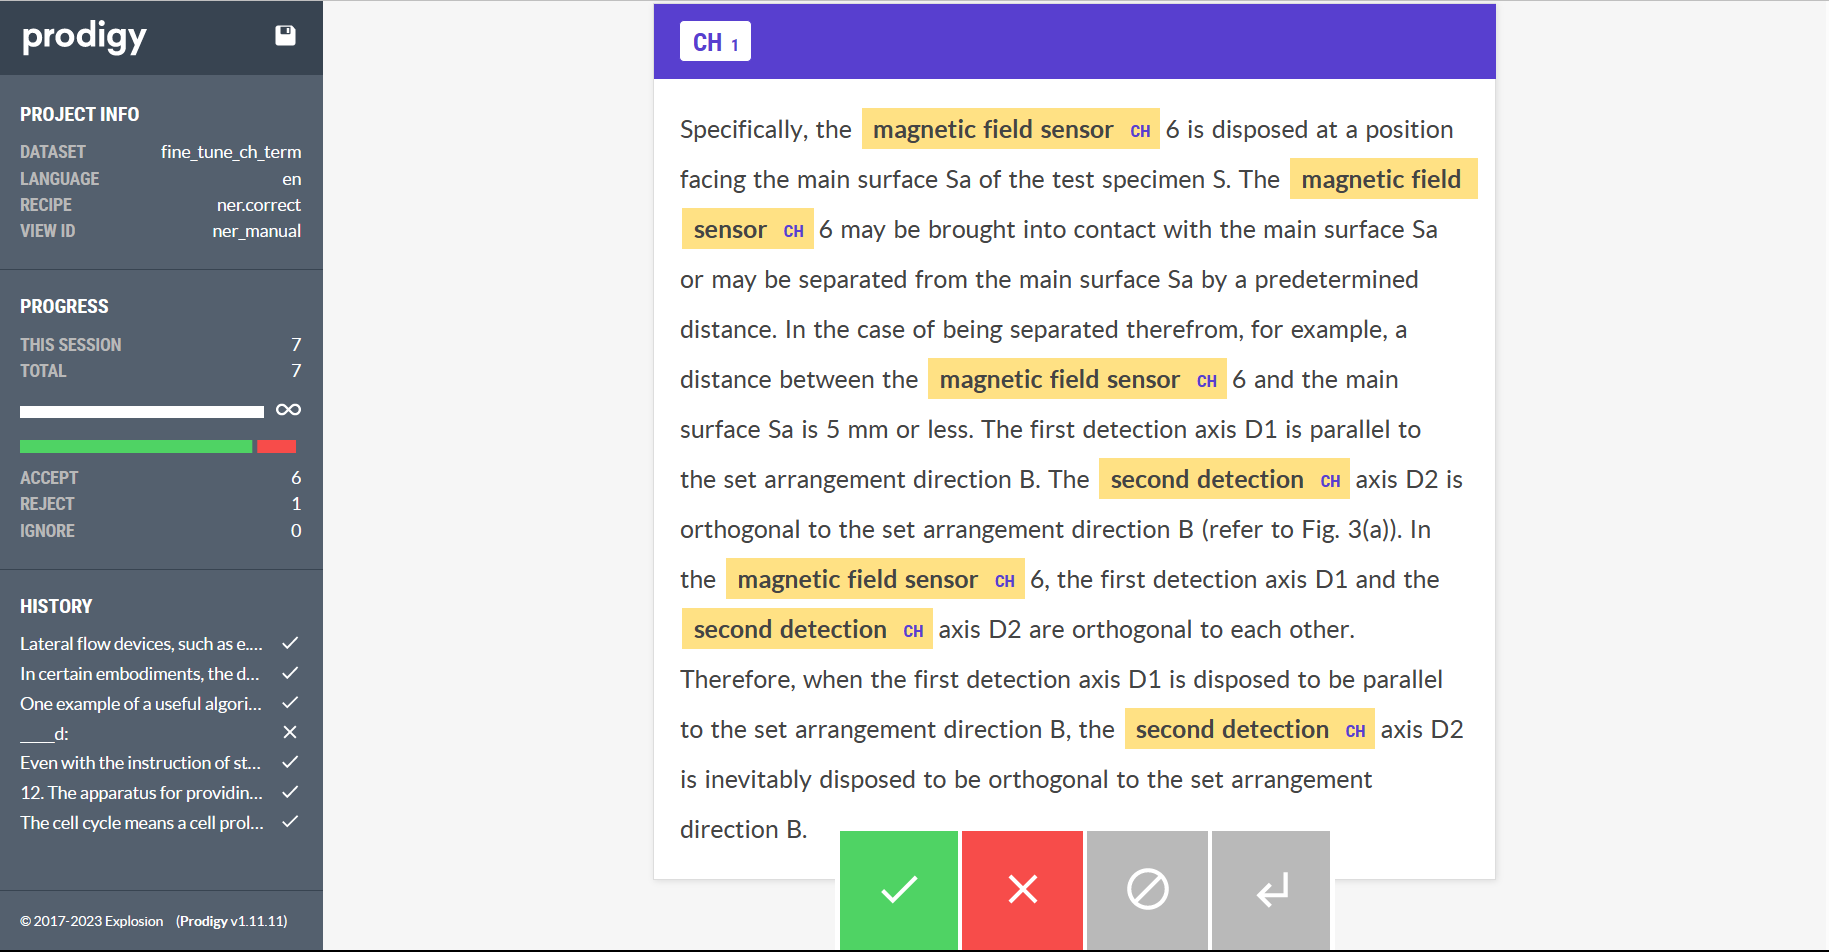

Save the train dataset after ner.correct

In [ ]:
#Uncomment if you want to save
#!python -m prodigy db-out fine_tune_ch_term ./prodigy_output/

Fine tuning

In [3]:
#uncomment if you want to use
#!python -m prodigy train ./prodigy_output/ --ner fine_tune_ch_term --base-model spacy_output/model-best 

ℹ Using CPU
ℹ To switch to GPU 0, use the option: --gpu-id 0

========================= Generating Prodigy config =========================
ℹ Auto-generating config with spaCy
ℹ Using config from base model
✔ Generated training config

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.01      0.02   36.57   53.85   27.68    0.37
  2     200      41642.08   1665.93   55.05   60.00   50.85    0.55
  5     400       4337.25    440.24   51.49   61.90   44.07    0.51
  8     600      10108.68    272.71   53.99   59.06   49.72    0.54
 11     800       2603.46    248.09   58.61   62.99   54.80    0.59
 15    1000       4201.31    212.77   55.69   59.

[2023-04-24 17:15:34,729] [INFO] Set up nlp object from config
Components: ner
Merging training and evaluation data for 1 components
  - [ner] Training: 85 | Evaluation: 21 (20% split)
Training: 85 | Evaluation: 21
Labels: ner (1)
[2023-04-24 17:15:34,800] [INFO] Pipeline: ['tok2vec', 'ner']
[2023-04-24 17:15:34,800] [INFO] Resuming training for: ['ner', 'tok2vec']
[2023-04-24 17:15:34,804] [INFO] Created vocabulary
[2023-04-24 17:15:36,915] [INFO] Added vectors: spacy_output/model-best
[2023-04-24 17:15:37,656] [INFO] Finished initializing nlp object
[2023-04-24 17:15:37,656] [INFO] Initialized pipeline components: []
Components: ner
Merging training and evaluation data for 1 components
  - [ner] Training: 85 | Evaluation: 21 (20% split)
Training: 85 | Evaluation: 21
Labels: ner (1)


### ✅Testing

In [53]:
# Load best model
nlp= spacy.load("./prodigy_output/model-best")
# Just text snippet
doc = nlp("""The scientific and technological terminologies referred to herein have the same meanings as what are generally understood by a person skilled in the art, and if there is a conflict, the definition in the present description shall prevail.
Firstly, in one aspect, the present invention provides a solid phase carrier (the solid phase carrier of the present invention) comprising:
a polydimethylsiloxane layer with an initiator on the surface, andtitanium dioxide particles distributed in said polydimethylsiloxane layer with an initiator on the surface.
Said polydimethylsiloxane with an initiator on the surface (iPDMS) belongs to the prior art, and reference can be made to Chinese Patent Publication No. CN 101265329 A.
Titanium dioxide, commonly known as titanium white, is usually a white powder. The crystal form of said titanium oxide is not particularly limited and may be, for example, of rutile type, anatase type or nanoscale ultrafine titanium dioxide.
Preferably, said titanium dioxide particles have an average particle size of 1 nm to 1000 nm, more preferably 5 nm to 500 nm""")

# Show NER results
spacy.displacy.render(doc, style="ent", jupyter=True)

### ✅Score : precision, recall, f1-score

In [54]:
#!python -m spacy evaluate ./prodigy_output/model-best ./test_data.spacy --output ./prodigy_output/eval.json

ℹ Using CPU

================================== Results ==================================

TOK     100.00
NER P   36.82 
NER R   13.13 
NER F   19.36 
SPEED   327   


=============================== NER (per type) ===============================

         P       R       F
CH   36.82   13.13   19.36

✔ Saved results to prodigy_output\eval.json


c:\Users\junio\anaconda3\lib\site-packages\spacy\util.py:887: UserWarning: [W095] Model 'en_pipeline' (0.0.0) was trained with spaCy v3.3 and may not be 100% compatible with the current version (3.5.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


#### ✅ Function to kill prodigy

In [45]:
for proc in process_iter():
    for conns in proc.connections(kind='inet'):
        if conns.laddr.port == 8080:
            print("killed process: ", proc.pid)
            os.system("taskkill  /F /pid "+str(proc.pid))
print("End of the massacre")

killed process:  24532
killed process:  24532
End of the massacre


## ✅Other thinks that we tried but not working

Remark
🔽

If you want to use transforme, just configure the  config file to GPU and inside the base_config.cfg file, change the base model to roberta-base or distilbert-base-uncased

We tried to fine tune transformers model such as Roberta-bas but it failed. 

RAM fills up fast, on Kaggle or Colab
we even tried to change the model in the base_config.cfg file to a lighter model like distillbert.

The training starts but also saturates the RAM at some point.
We wanted to use the transformers model in order to see how it performs compared to the spacy model. we wanted to compare the results of the two models.

# 2- Relation Extraction

✔️ what we call relation  here ?

Relation is a verb or verb phrase that lies between two entities and indicates how the entities are related.

### ✅Useful functions

This function is used to extract the relation from the sentence. It takes as input a sentence and a list of terms and returns a list of relations. This relation is a verb or verb phrase that connects two terms.

In [25]:
def get_predicates_between_noun_chunks(doc, noun_chunks):
    predicates = []
    sources = []
    targets = []

    for i in range(len(noun_chunks) - 1):
        start_chunk_token = doc.char_span(
            noun_chunks[i]['start'], noun_chunks[i]['end'])
        end_chunk_token = doc.char_span(
            noun_chunks[i + 1]['start'], noun_chunks[i + 1]['end'])
        
        if start_chunk_token is None or end_chunk_token is None or start_chunk_token.sent != end_chunk_token.sent:
            continue

        # Find the shortest path between the root tokens of the neighboring noun chunks
        start_token = start_chunk_token.root
        end_token = end_chunk_token.root

        # not ideal, can possibly be shortened:
        predicate_tokens = []
        if start_token in end_token.ancestors:
            ancs = end_token.ancestors
            stop = start_token
        elif end_token in start_token.ancestors:
            ancs = start_token.ancestors
            stop = end_token
        else:
            for token in end_token.ancestors:
                if token.pos_ == 'AUX'or token.pos_ == 'VERB' : # if token is a verb or auxilliary verb 
                    predicate_tokens.append(token)
                if token in end_token.ancestors:
                    break
            ancs = end_token.ancestors
            stop = token
        for tok in ancs:
            if tok == stop:
                break
            predicate_tokens += [tok]
    

        if not predicate_tokens:
            continue
        predicate_tokens = sorted(
            predicate_tokens, key=lambda token: token.i)
        predicate_text = ' '.join(token.text for token in predicate_tokens)
        start_char = predicate_tokens[0].idx
        end_char = start_char + len(predicate_text)
        
        predicates.append({
            'start': start_char,
            'end': end_char,
            'label': 'PRED',
            'text': predicate_text
        })
        sources += [start_chunk_token]
        targets += [end_chunk_token]
    return predicates, sources, targets

In [26]:
def display_predicate_bet_entities(sources, predicates, targets):
    """Display a predicate between two entities."""
    df = pd.DataFrame({'source': [str(s) for s in sources], 
                        'edge': [r['text'] for r in predicates],
                    'target': [str(t) for t in targets]}
                    )
    df.drop_duplicates(inplace=True) # remove duplicates (if any)
    return df

### ✅By using Noun chunks of our patents we have : 

+ Doing some processing on patent text by remove reference numbers and getting noun chunks

In [23]:
shortText=patent_texts[0] # first patent
num2termlist = rawExtractRefs(shortText) # extract references
cleanNshort = removeNumbers(shortText, num2termlist) # remove references

doc=nlp(cleanNshort)
get_noun_chunks(doc)
noun_chunks = get_noun_chunks(doc, remove_list, exclude_list)

# get predicates between noun chunks
predicates, sources, targets = get_predicates_between_noun_chunks(
    doc, noun_chunks)

Here I wanted to install the coreference module in order to use it to replace the pronouns with the noun they refer to. And then use it with noun chunk to see how it performs. But I couldn't install it. Don't really know why.

In [ ]:
# !pip install neuralcoref failled 

+ Display the relation between two entities

In [85]:
df=display_predicate_bet_entities(sources, predicates, targets)
df

,source,edge,target
0,polydimethylsiloxane layer,provided,titanium dioxide particles distributed
1,titanium dioxide particles distributed,distributed in,polydimethylsiloxane layer
2,polydimethylsiloxane,abbreviated as,PDMS hereinafter
3,chemical inertness,become,functional material
4,functional material,in fields of applications including,microfluidic systems
5,PDMS-based device,perform,surface modification
6,surface modification,of,PDMS
7,Chinese Patent Publication,disclosed,polydimethylsiloxane
8,polydimethylsiloxane,with initiator on surface,initiator-integrated polydimethylsiloxane
9,initiator-integrated polydimethylsiloxane,is,polydimethylsiloxane material


Remarks:
🔽

We can see here that the model recognize relations not really related to our domains. so relation is not meagningful

### ✅BY using our Ner model that we fine tuning with prodigy we have :

+ First we need to load our model and extract terms from our patents using our model. Put the terms in the right format to use it in the function extracting predicate.

In [80]:
nlp_ner= spacy.load('.\prodigy_output\model-best')
nlp_ner.add_pipe('sentencizer')
doc = nlp_ner(cleanNshort)

list_entity=[{'start': ent.start_char,
            'end': ent.end_char,
            'label': ent.label_,
            'text': ent.text} for ent in doc.ents]
list_entity[0:10]

c:\Users\junio\anaconda3\lib\site-packages\spacy\util.py:887: UserWarning: [W095] Model 'en_pipeline' (0.0.0) was trained with spaCy v3.3 and may not be 100% compatible with the current version (3.5.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


[{'start': 0, 'end': 19, 'label': 'CH', 'text': 'SOLID-PHASE CARRIER'},
 {'start': 367,
  'end': 393,
  'label': 'CH',
  'text': 'polydimethylsiloxane layer'},
 {'start': 432,
  'end': 470,
  'label': 'CH',
  'text': 'titanium dioxide particles distributed'},
 {'start': 479,
  'end': 505,
  'label': 'CH',
  'text': 'polydimethylsiloxane layer'},
 {'start': 849, 'end': 858, 'label': 'CH', 'text': 'substrate'},
 {'start': 877, 'end': 897, 'label': 'CH', 'text': 'polydimethylsiloxane'},
 {'start': 914, 'end': 930, 'label': 'CH', 'text': 'PDMS hereinafter'},
 {'start': 965, 'end': 977, 'label': 'CH', 'text': 'non-toxicity'},
 {'start': 993, 'end': 1003, 'label': 'CH', 'text': 'elasticity'},
 {'start': 1009, 'end': 1027, 'label': 'CH', 'text': 'chemical inertness'}]

+ get the relation between two entities

In [81]:
doc=nlp(cleanNshort)
pred, sour, tar = get_predicates_between_noun_chunks(
    doc,list_entity)

In [91]:
df_1=display_predicate_bet_entities(sour, pred, tar)
df_1

,source,edge,target
0,polydimethylsiloxane layer,provided,titanium dioxide particles distributed
1,titanium dioxide particles distributed,distributed in,polydimethylsiloxane layer
2,polydimethylsiloxane,abbreviated as,PDMS hereinafter
3,chemical inertness,become,functional material
4,functional material,in fields of applications including,microfluidic systems
5,PDMS-based device,perform,surface modification
6,surface modification,of,PDMS
7,Chinese Patent Publication,disclosed,polydimethylsiloxane
8,polydimethylsiloxane,with initiator on surface,initiator-integrated polydimethylsiloxane
9,initiator-integrated polydimethylsiloxane,is,polydimethylsiloxane material


In [157]:
displacy.render(doc, style="dep")

+ Uncomment the cell below if you want to see the relation between two entities physically

In [ ]:
~#displacy.render({'text': cleanNshort, 'ents': list_entity + predicates,
              # 'title': None}, style='ent', manual=True, jupyter=True, options={'colors': {"PRED": 'red'}})

+ knowledges with the entities  extract from the first patent 

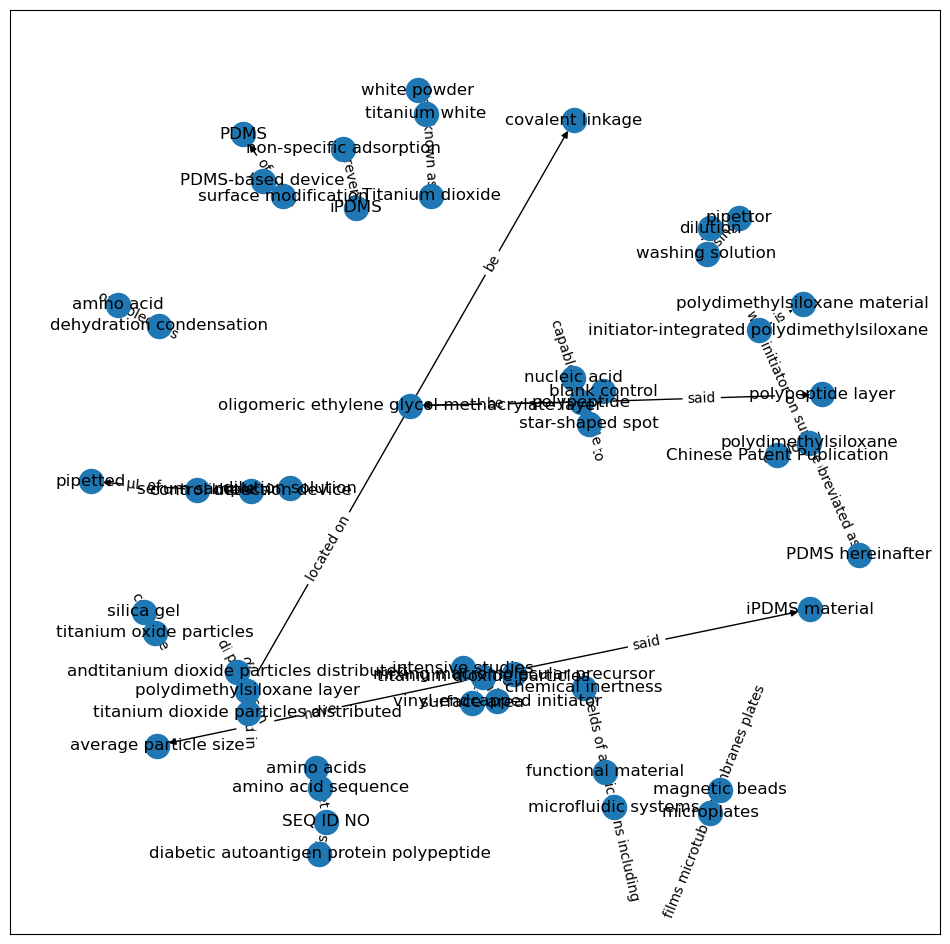

In [125]:
G = nx.from_pandas_edgelist(df_1, "source", "target",
                            edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G)
nx.draw_networkx(G, with_labels=True, pos=pos)

# Add edge labels
edge_labels = {(row['source'], row['target']): row['edge'] for _, row in df.iterrows()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()

### ✅ By using Textacy to extract verb phrases

+ Install textacy

In [ ]:
#!pip install textacy

+ With our model :
Don't work 

In [ ]:
nlp_ner= spacy.load('.\prodigy_output\model-best')
nlp_ner.add_pipe ('sentencizer')
nlp_ner.add_pipe('tagger', source=nlp)
nlp_ner.add_pipe('attribute_ruler', source=nlp)
nlp_ner.add_pipe('parser', source=nlp)
nlp_ner.add_pipe('sentencizer', source=nlp)
doc = nlp_ner(cleanNshort)
#doc=nlp(doc)

In [ ]:
patterns = [{"POS": "AUX"}, {"POS": "VERB"}]
#about_talk_doc = textacy.make_spacy_doc(doc, lang=".\prodigy_output\model-best")
verb_phrases = textacy.extract.token_matches(doc, patterns=patterns)
print(verb_phrases)

#Print all verb phrases
for chunk in verb_phrases:
    print(chunk.text)

#for chunk in doc.noun_chunks:
    #print (chunk)

Remarks:
🔽

We do not know why we got an error for the dependency models. We have added what they ask for but we can't use our model with textacy.
But we can use it with the spacy models.

+ With spacy model 

In [42]:
patterns = [{"POS": "AUX"}, {"POS": "VERB"}]
about_talk_doc = textacy.make_spacy_doc(cleanNshort, lang="en_core_web_lg")
verb_phrases = textacy.extract.token_matches(about_talk_doc, patterns=patterns)

#Print all verb phrases
#for chunk in verb_phrases:
    #print(chunk.text)

#for chunk in about_talk_doc.noun_chunks:
    #print (chunk)